In [2]:

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
from folium import IFrame
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from branca.colormap import LinearColormap

In [3]:
us_airport_loc = pd.read_csv('./us_airport_loc.csv')
print(us_airport_loc.info())

lat_mean = us_airport_loc['LATITUDE'].mean()
lon_mean = us_airport_loc['LONGITUDE'].mean()
lat_max = us_airport_loc['LATITUDE'].max()
lat_min = us_airport_loc['LATITUDE'].min()
lon_max = us_airport_loc['LONGITUDE'].max()
lon_min = us_airport_loc['LONGITUDE'].min()

shp_file_path = 'States_shapefile-shp/States_shapefile.shp'


def get_airport_location(airport_code):
    airport = us_airport_loc[us_airport_loc['Name'] == airport_code]
    if airport.empty:
        print(f"No location data found for airport {airport_code}")
        return None
    else:
        lat = airport['LATITUDE'].values[0]
        lon = airport['LONGITUDE'].values[0]
        return lat, lon

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Name       70 non-null     object 
 1   AIRPORT    70 non-null     object 
 2   CITY       70 non-null     object 
 3   STATE      70 non-null     object 
 4   COUNTRY    70 non-null     object 
 5   LATITUDE   70 non-null     float64
 6   LONGITUDE  70 non-null     float64
dtypes: float64(2), object(5)
memory usage: 4.0+ KB
None


In [4]:
weather = np.load('udata/weather2016_2021.npy').T
print(weather.shape)

(78912, 70)


In [5]:
u_mx = np.load('./udata/udelay.npy')
print(u_mx.shape)

arr = u_mx[:, :, 0].T
dep = u_mx[:, :, 1].T

df_arr = pd.DataFrame(arr, index=range(
    78912), columns=us_airport_loc['Name'].tolist())
df_dep = pd.DataFrame(dep, index=range(
    78912), columns=us_airport_loc['Name'].tolist())
df_weather = pd.DataFrame(weather, index=range(78912), columns=us_airport_loc['Name'].tolist())

print(df_weather.shape)


(70, 78912, 2)
(78912, 70)


In [6]:
from datetime import datetime, timedelta

def calculate_time(t):
    start_time = datetime(2016, 1, 1, 6, 0)
    time_interval = timedelta(minutes=30)
    real_time = start_time + t * time_interval
    if real_time.hour < 6:
        real_time = datetime(real_time.year, real_time.month, real_time.day, 6, 0)

    return real_time.strftime("%Y.%m.%d, %H:%M")

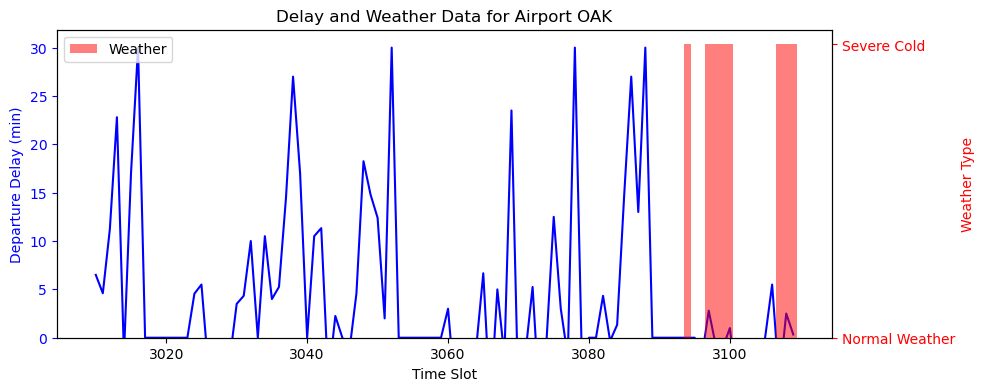

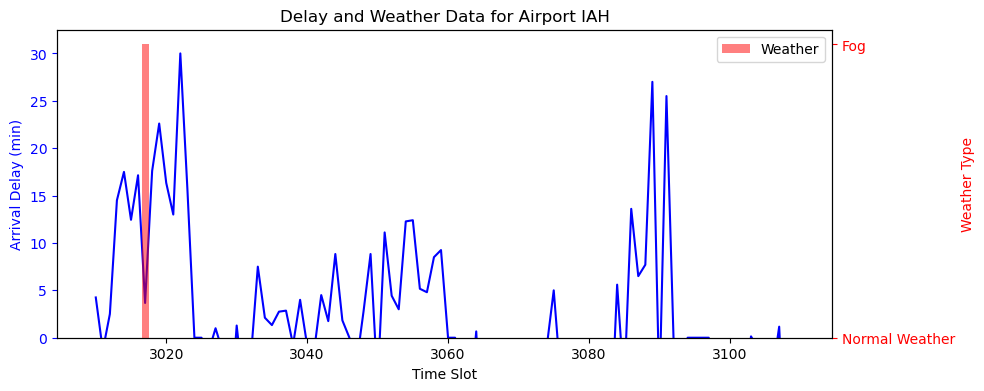

In [11]:
weather_descriptions = {
    0: 'Normal Weather',
    1: 'Severe Cold',
    2: 'Fog',
    3: 'Hail',
    4: 'Rain',
    5: 'Snow',
    6: 'Storm',
    7: 'Other Precipitation'
}


def get_delay_time(time_slot, airport_code):
    arr_delay = df_arr.loc[time_slot, :].fillna(0)
    dep_delay = df_dep.loc[time_slot, :].fillna(0)
    weather = df_weather.loc[time_slot, :].fillna(0)

    arr = arr_delay[airport_code]
    dep = dep_delay[airport_code]
    weather_data = weather[airport_code]

    return arr, dep, weather_data


def plot_data(airport_code, time_range, delay_type):
    fig, ax1 = plt.subplots(figsize=(10, 4))

    delay_data = [get_delay_time(i, airport_code) for i in time_range]
    if delay_type == 0:
        label = 'Arrival Delay (min)'
    elif delay_type == 1:
        label = 'Departure Delay (min)'
    ax1.plot(time_range, [d[delay_type]
                         for d in delay_data], label=label, color='blue')
    ax1.set_xlabel('Time Slot')
    ax1.set_ylabel(label, color='blue')
    ax1.tick_params('y', colors='blue')
    ax1.set_ylim(ymin=0)

    ax2 = ax1.twinx()
    ax2.bar(time_range, [weather_descriptions[d[2]] for d in delay_data],
            color='red', alpha=0.5, label='Weather', width=1)
    ax2.set_ylabel('Weather Type', color='red')
    ax2.tick_params('y', colors='red')

    plt.title(f'Delay and Weather Data for Airport {airport_code}')
    plt.legend()
    plt.show()


start = 3010
delta = 100
time_range = range(start, start+delta)
# plot_data(airport, time range, arr/dep)
# plot_data('JFK', time_range, 0)
plot_data('OAK', time_range, 1)
plot_data('IAH', time_range, 0)

In [8]:
def plot_map(ax, time_slot, delay_type='dep'):
    map = Basemap(width=11000000, height=5500000,
                  rsphere=(6378137.00, 6356752.3142),
                  resolution='l', area_thresh=1000., projection='lcc',
                  lat_1=45., lat_2=55, lat_0=45, lon_0=-110., ax=ax)
    map.drawcoastlines(linewidth=0.5)
    map.drawstates(linewidth=0.5)
    map.drawcountries(linewidth=1.5)
    map.fillcontinents(color='lightgray')
    # map.fillcontinents(color='lightgray', lake_color='lightblue')
    # map.drawmapboundary(fill_color='lightblue')
    plot_airports(ax, map, s=40, time_slot=time_slot, delay_type=delay_type)
    return map


def plot_airports(ax, map, s, time_slot, delay_type):
    time_slot = time_slot

    arr_delay = df_arr.loc[time_slot, :].fillna(0)
    dep_delay = df_dep.loc[time_slot, :].fillna(0)

    cmap = plt.get_cmap('jet')
    norm = plt.Normalize(-10, 30)

    for airport in us_airport_loc['Name']:
        lat, lon = get_airport_location(airport)
        x, y = map(lon, lat)
        arr = arr_delay[airport]
        dep = dep_delay[airport]

        if delay_type == 'arr':
            size = s * norm(arr)
            color = cmap(norm(arr))
            data = arr
        elif delay_type == 'dep':
            size = s * norm(dep)
            color = cmap(norm(dep))
            data = dep

        size = max(0, size)
        res = []
        if data > 10:
            res.append([airport, data])
            ax.text(x, y, airport, fontsize=15, color='black', ha='center', va='center')

        map.scatter(x, y, s=size*size+100, color=color, marker='o', alpha=0.8)

        for i in res:
            print("Time Slot: %d, Airport: %s, Delay: %f, Type: %s" % (time_slot, airport, data, delay_type))


def plot_flight_route(dep, arr, map, linewidth=2, color='b', alpha=1.0):
    dep_lat, dep_lon = get_airport_location(dep)
    arr_lat, arr_lon = get_airport_location(arr)
    map.drawgreatcircle(dep_lon, dep_lat, arr_lon,
                        arr_lat, linewidth=linewidth, color=color, alpha=alpha)

Time Slot: 0, Airport: ABQ, Delay: 12.333333, Type: dep
Time Slot: 0, Airport: HNL, Delay: 19.666667, Type: dep
Time Slot: 0, Airport: OAK, Delay: 18.000000, Type: dep
Time Slot: 0, Airport: OKC, Delay: 30.000000, Type: dep
Time Slot: 0, Airport: OMA, Delay: 12.000000, Type: dep
Time Slot: 0, Airport: ONT, Delay: 11.000000, Type: dep
Time Slot: 0, Airport: PIT, Delay: 22.000000, Type: dep
Time Slot: 2, Airport: DCA, Delay: 15.333333, Type: dep
Time Slot: 2, Airport: TPA, Delay: 12.000000, Type: dep
Time Slot: 5, Airport: BWI, Delay: 10.307692, Type: dep
Time Slot: 5, Airport: DAL, Delay: 14.000000, Type: dep
Time Slot: 5, Airport: HOU, Delay: 10.333333, Type: dep
Time Slot: 5, Airport: TUL, Delay: 10.500000, Type: dep
Time Slot: 11, Airport: IND, Delay: 10.200000, Type: dep
Time Slot: 11, Airport: JFK, Delay: 14.500000, Type: dep
Time Slot: 11, Airport: MCI, Delay: 13.250000, Type: dep


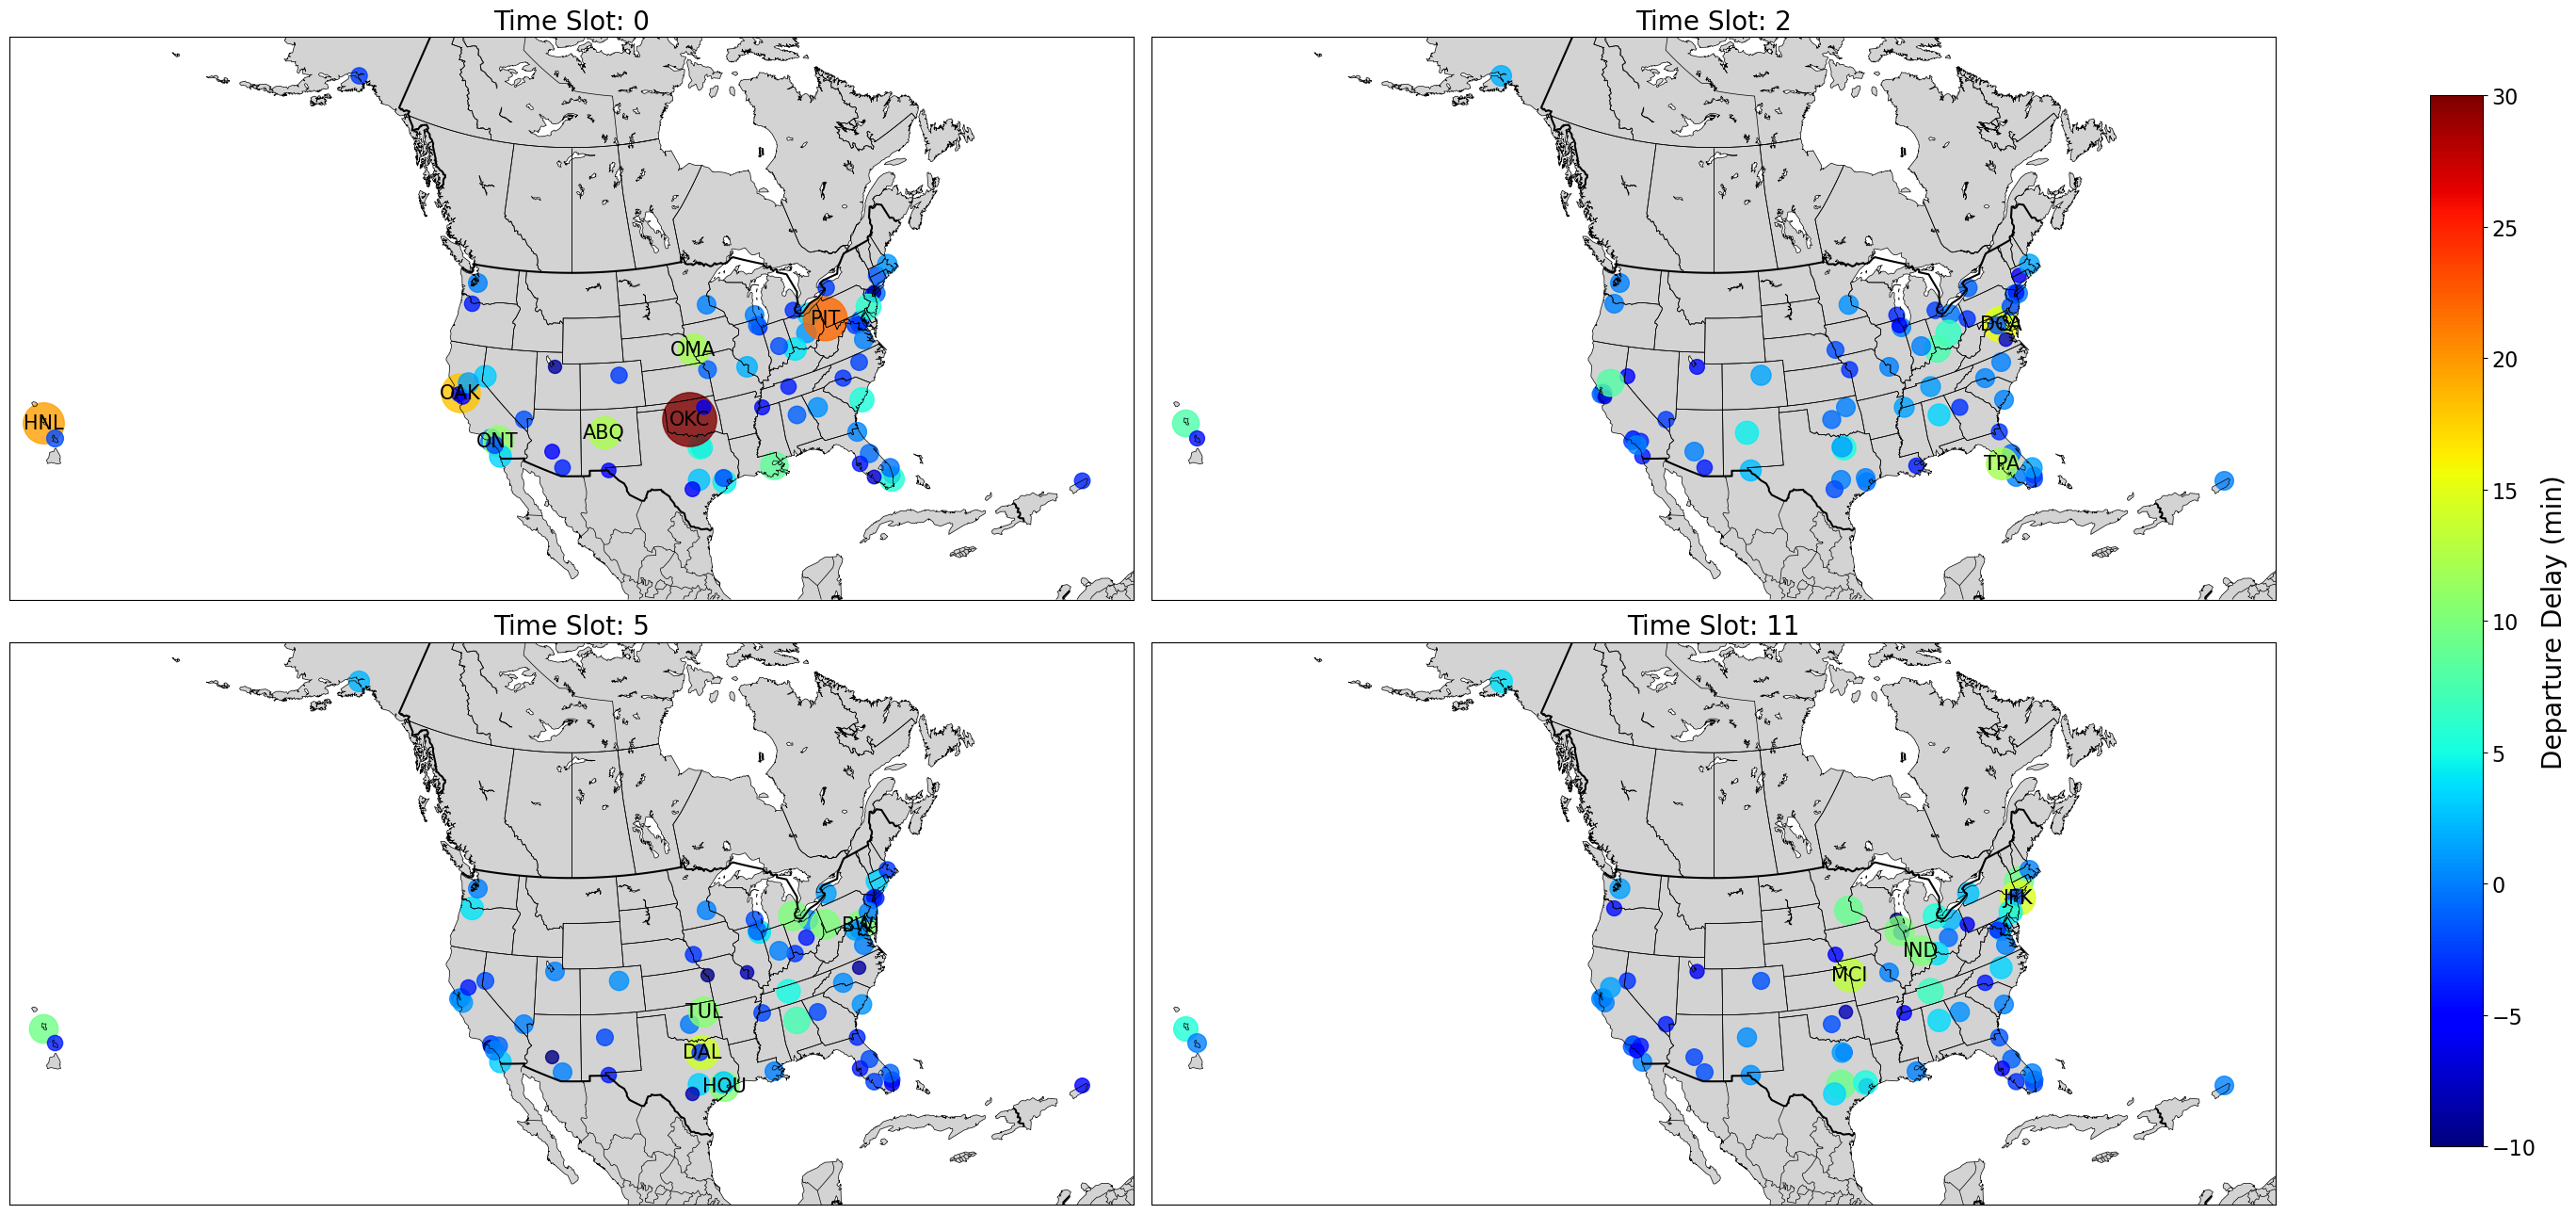

2016.01.01, 06:00
2016.01.01, 07:00
2016.01.01, 08:30
2016.01.01, 11:30


In [9]:
# Create a 2x2 grid for the subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(33, 13))

# Plot each map in a subplot
time = [0, 2, 5, 11]
plot_map(axes[0, 0], 0, 'dep')
plot_map(axes[0, 1], 2, 'dep')
plot_map(axes[1, 0], 5, 'dep')
plot_map(axes[1, 1], 11, 'dep')

axes[0, 0].set_title('Time Slot: 0', fontsize=20)
axes[0, 1].set_title('Time Slot: 2', fontsize=20)
axes[1, 0].set_title('Time Slot: 5', fontsize=20)
axes[1, 1].set_title('Time Slot: 11', fontsize=20)

plt.tight_layout()

norm = plt.Normalize(-10, 30)
cmap = plt.get_cmap('jet')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, label='Departure Delay (min)', shrink=0.9, ax=axes)
cbar.set_label('Departure Delay (min)', fontsize=20)
cbar.ax.tick_params(labelsize=16)

plt.show()
for t in time:
    print(calculate_time(t))

Time Slot: 0, Airport: BWI, Delay: 10.285714, Type: arr
Time Slot: 0, Airport: SFO, Delay: 19.000000, Type: arr
Time Slot: 2, Airport: ABQ, Delay: 18.000000, Type: arr
Time Slot: 2, Airport: BWI, Delay: 12.333333, Type: arr
Time Slot: 2, Airport: MSP, Delay: 30.000000, Type: arr
Time Slot: 2, Airport: SFO, Delay: 17.000000, Type: arr
Time Slot: 5, Airport: HNL, Delay: 30.000000, Type: arr
Time Slot: 11, Airport: SFO, Delay: 30.000000, Type: arr


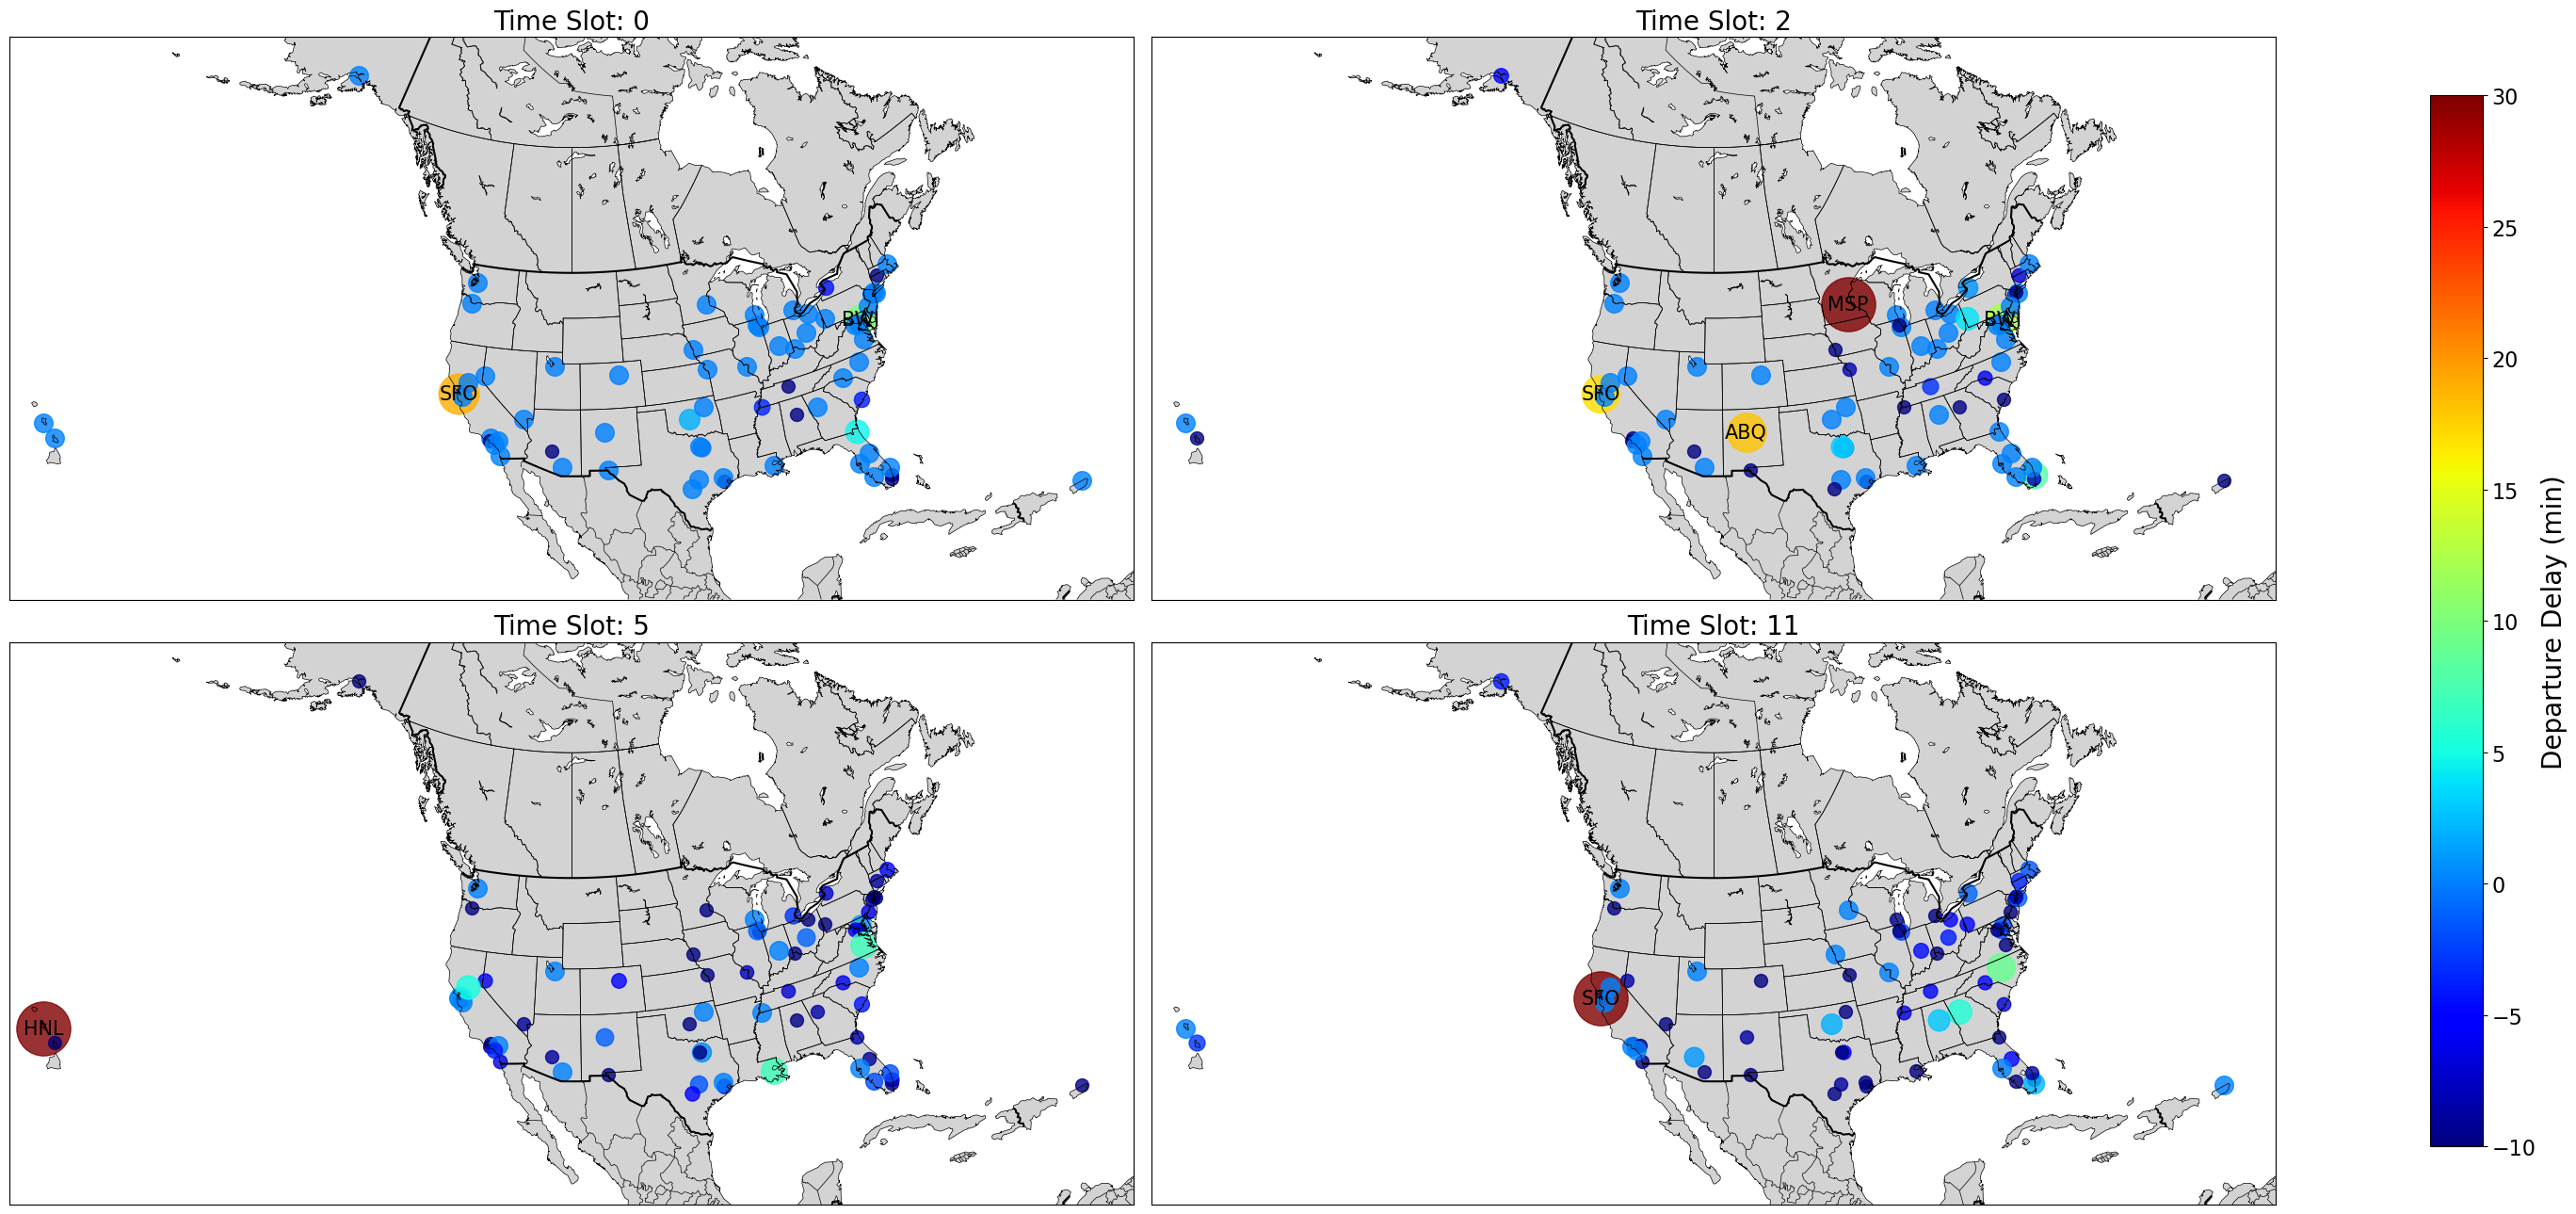

2016.01.01, 06:00
2016.01.01, 07:00
2016.01.01, 08:30
2016.01.01, 11:30


In [10]:
# Create a 2x2 grid for the subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(33, 13))

# Plot each map in a subplot
time = [0, 2, 5, 11]
plot_map(axes[0, 0], 0, 'arr')
plot_map(axes[0, 1], 2, 'arr')
plot_map(axes[1, 0], 5, 'arr')
plot_map(axes[1, 1], 11, 'arr')

axes[0, 0].set_title('Time Slot: 0', fontsize=20)
axes[0, 1].set_title('Time Slot: 2', fontsize=20)
axes[1, 0].set_title('Time Slot: 5', fontsize=20)
axes[1, 1].set_title('Time Slot: 11', fontsize=20)

plt.tight_layout()

norm = plt.Normalize(-10, 30)
cmap = plt.get_cmap('jet')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, label='Departure Delay (min)', shrink=0.9, ax=axes)
cbar.set_label('Departure Delay (min)', fontsize=20)
cbar.ax.tick_params(labelsize=16)

plt.show()
for t in time:
    print(calculate_time(t))

Time Slot: 3016, Airport: ABQ, Delay: 25.818182, Type: dep
Time Slot: 3016, Airport: ANC, Delay: 20.785714, Type: dep
Time Slot: 3016, Airport: ATL, Delay: 11.846154, Type: dep
Time Slot: 3016, Airport: AUS, Delay: 20.200000, Type: dep
Time Slot: 3016, Airport: BDL, Delay: 18.714286, Type: dep
Time Slot: 3016, Airport: BOS, Delay: 16.750000, Type: dep
Time Slot: 3016, Airport: CHS, Delay: 30.000000, Type: dep
Time Slot: 3016, Airport: DCA, Delay: 17.333333, Type: dep
Time Slot: 3016, Airport: DEN, Delay: 22.285714, Type: dep
Time Slot: 3016, Airport: DFW, Delay: 16.125000, Type: dep
Time Slot: 3016, Airport: DTW, Delay: 29.250000, Type: dep
Time Slot: 3016, Airport: ELP, Delay: 18.909091, Type: dep
Time Slot: 3016, Airport: EWR, Delay: 14.000000, Type: dep
Time Slot: 3016, Airport: FLL, Delay: 10.333333, Type: dep
Time Slot: 3016, Airport: HNL, Delay: 13.421053, Type: dep
Time Slot: 3016, Airport: HOU, Delay: 20.000000, Type: dep
Time Slot: 3016, Airport: IAH, Delay: 18.428571, Type: d

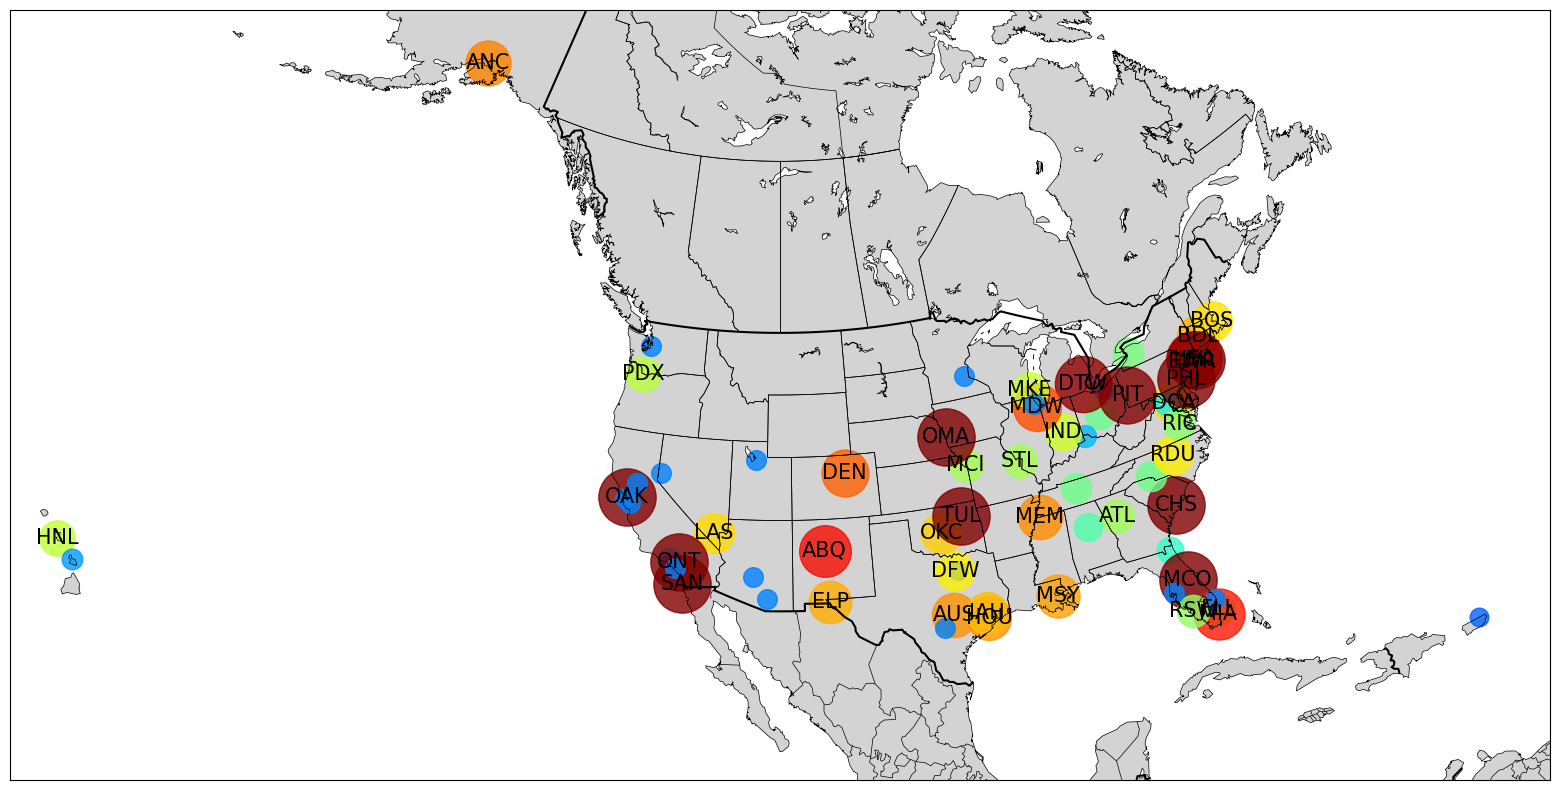

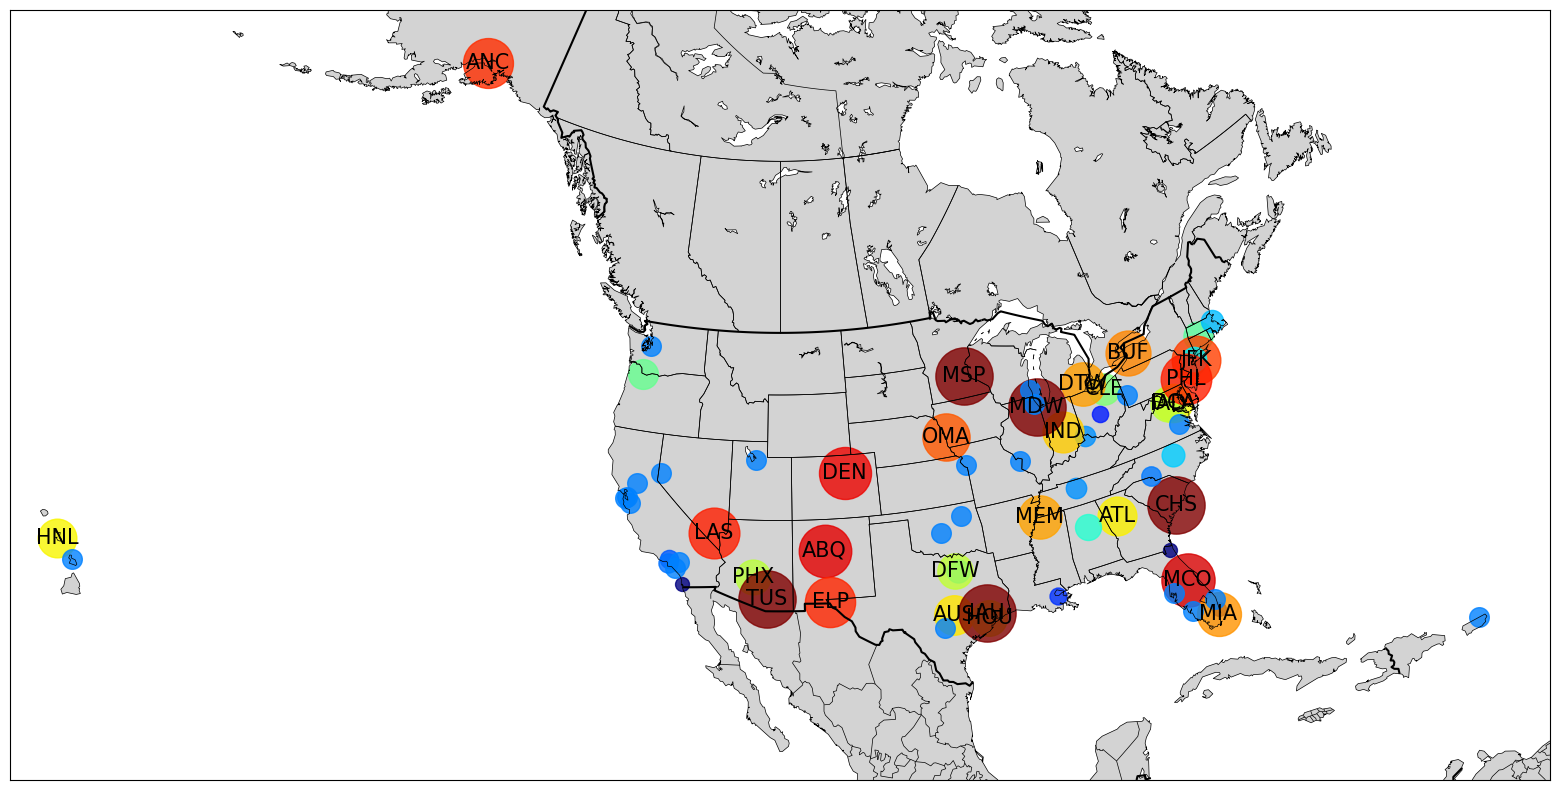

In [12]:
fig, ax = plt.subplots(figsize=(20, 10))
map = plot_map(ax, 3016, 'dep')
fig, ax = plt.subplots(figsize=(20, 10))
map = plot_map(ax, 3022, 'arr')

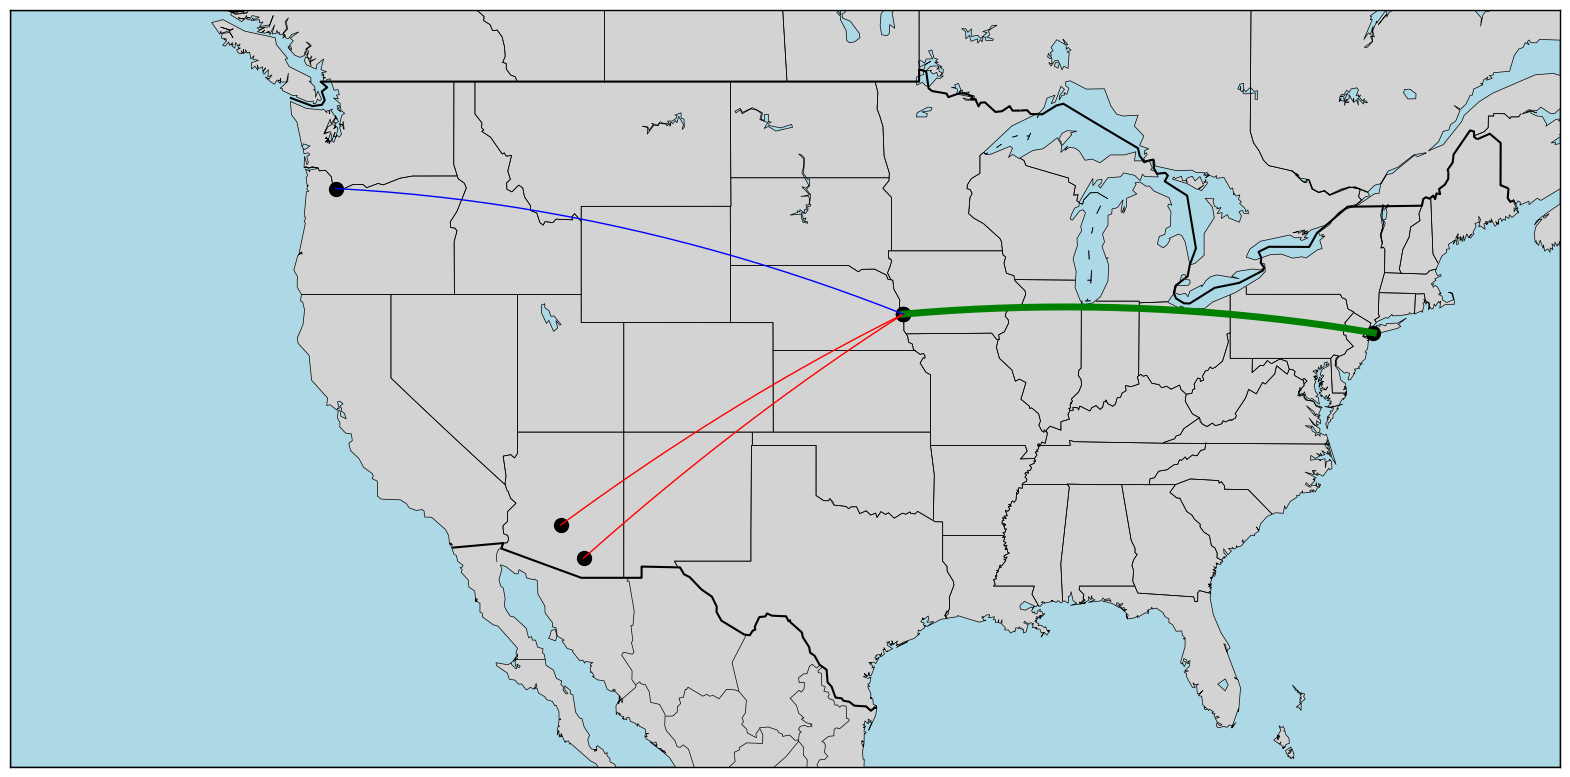

In [12]:
def plot_map(ax, time_slot, delay_type='dep'):
    map = Basemap(llcrnrlon=lon_min+20, llcrnrlat=lat_min+5,
                  urcrnrlon=lon_max+1, urcrnrlat=lat_max-10,
                  resolution='l', projection='merc', ax=ax)
    # map.bluemarble()
    map.drawcoastlines(linewidth=0.5)
    map.drawstates(linewidth=0.5)
    map.drawcountries(linewidth=1.5)
    map.fillcontinents(color='lightgray')
    map.fillcontinents(color='lightgray', lake_color='lightblue')
    map.drawmapboundary(fill_color='lightblue')
    return map


def plot_flight_route(dep, arr, map, linewidth=2, color='b', alpha=1.0):
    dep_lat, dep_lon = get_airport_location(dep)
    arr_lat, arr_lon = get_airport_location(arr)
    map.drawgreatcircle(dep_lon, dep_lat, arr_lon,
                        arr_lat, linewidth=linewidth, color=color, alpha=alpha)
    x1, y1 = map(dep_lon, dep_lat)
    x2, y2 = map(arr_lon, arr_lat)
    map.scatter(x1, y1, s=100, color='black', marker='o', alpha=1.0)
    map.scatter(x2, y2, s=100, color='black', marker='o', alpha=1.0)


fig, ax = plt.subplots(figsize=(20, 10))

map = plot_map(ax, 5016, 'dep')

plot_flight_route('OMA', 'JFK', map, linewidth=5, color='g', alpha=1.0)
plot_flight_route('OMA', 'PHX', map, linewidth=1, color='r', alpha=1.0)
plot_flight_route('OMA', 'TUS', map, linewidth=1, color='r', alpha=1.0)
plot_flight_route('OMA', 'PDX', map, linewidth=1, color='b', alpha=1.0)

plt.show()

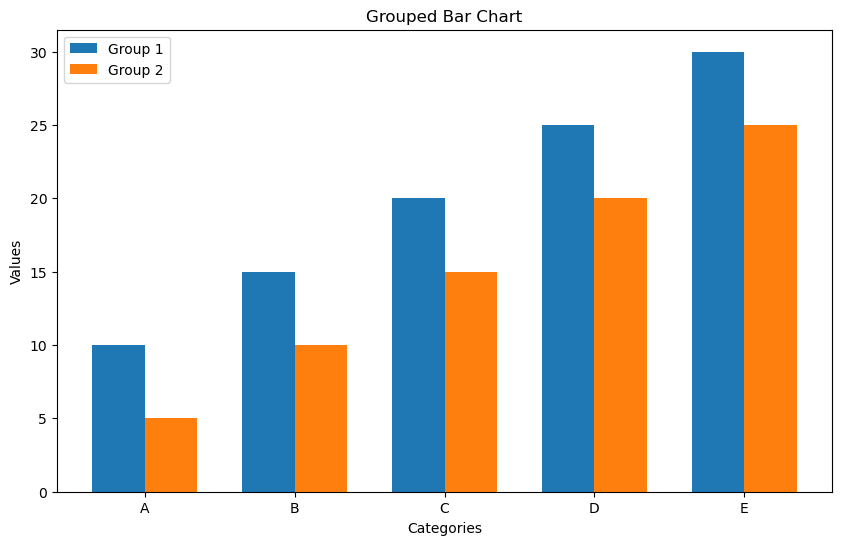

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 假设 data1 和 data2 是两组数据
data1 = [10, 15, 20, 25, 30]
data2 = [5, 10, 15, 20, 25]
categories = np.arange(len(data1))

fig, ax = plt.subplots(figsize=(10, 6))

# 使用 plt.bar 绘制分组柱状图
bar_width = 0.35
plt.bar(categories - bar_width/2, data1, label='Group 1', width=bar_width)
plt.bar(categories + bar_width/2, data2, label='Group 2', width=bar_width)

plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Grouped Bar Chart')
plt.xticks(categories, ['A', 'B', 'C', 'D', 'E'])
plt.legend()
plt.show()
